### Setup
```sh
python3.10 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from IPython.display import display, clear_output
from tqdm.auto import tqdm
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import netCDF4 as nc
from eofs.standard import Eof


### Preparing Data

In [2]:
trY_SST_ds=nc.Dataset("GISS-E2-1-H_historical_1850_2014.nc", decode_times=False)

trY_SST=trY_SST_ds.variables['sst'][:,:,:,:,:].data
mask=1-trY_SST_ds.variables['sst'][0,0,0,:,:].mask

In [3]:
trY_SST=trY_SST[:,21:-4,:,:]  #1871 - 2010
trY_SST=np.nan_to_num(trY_SST)

trY_SST_anom = trY_SST-np.expand_dims(trY_SST.mean(1),1)
trY_SST=trY_SST.reshape(trY_SST.shape[0],1680,48,144)

trY_SST_train=trY_SST[:,:1428] #1871-1989
trY_SST_test=trY_SST[:, 1428:].mean(axis=0) #1990-2010

In [4]:
X_train=trY_SST_train[:,:-1,:,:]
Y_train=trY_SST_train[:,1:,:,:]

X_test=trY_SST_test[:-1,:,:]
Y_test=trY_SST_test[1:,:,:]

lat_sst=trY_SST_ds.variables['lat'][:]
lon_sst=trY_SST_ds.variables['lon'][:]

In [5]:
def plot_map(lon,lat,data,file_name):
    m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(lat_sst), urcrnrlat=np.max(lat_sst),
            llcrnrlon=np.min(lon_sst), urcrnrlon=np.max(lon_sst))
    
    lons,lats= np.meshgrid(lon,lat)
    x,y = m(lons,lats)
    
    levels = np.linspace(min(np.unique(data)),max(np.unique(data)),21)
    
    temp = m.contourf(x,y,data,levels=levels,cmap='seismic')

    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(0., 361., 45.), labels=[0, 0, 0, 1])

    plt.savefig(file_name)
    
    plt.show()
    plt.clf()

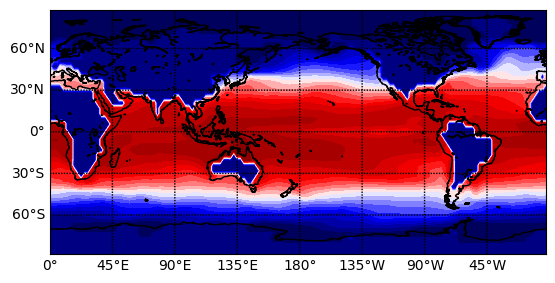

<Figure size 640x480 with 0 Axes>

In [6]:
plot_map(lon_sst, lat_sst, X_train[0,0,:,:], 'file.png')

### Model

In [8]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # reducing size to half
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(32 * 12 * 36, 128)  # Adjust size according to output of last conv layer
        self.fc_mean = nn.Linear(128, 50)
        self.fc_log_var = nn.Linear(128, 50)
        
        # Decoder
        self.fc2 = nn.Linear(50, 128)
        self.fc3 = nn.Linear(128, 32 * 12 * 36)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.fc1(x)
        return self.fc_mean(x), self.fc_log_var(x)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        z = F.relu(self.fc2(z))
        z = self.fc3(z)
        z = z.view(-1, 32, 12, 36)
        return self.decoder(z)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        return self.decode(z), mean, log_var


### Dataset Class

In [9]:
class GeoDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_item = self.data[idx]
        normalized_data = self.normalize_data(data_item)
        return normalized_data
    
    @staticmethod
    def normalize_data(data):
        data_min = data.min()
        data_max = data.max()
        return (data - data_min) / (data_max - data_min)

In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 48, 144)

train_dataset = GeoDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

X_val_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 48, 144)

val_dataset = GeoDataset(X_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Loss

In [11]:
class VAELoss(nn.Module):
    def __init__(self, beta=1.0):
        super(VAELoss, self).__init__()
        self.beta = beta

    def forward(self, recon_x, x, mean, log_var):
        BCE = F.mse_loss(recon_x, x, reduction='sum')
        KL = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return (BCE + self.beta * KL) / x.size(0)


### Training

In [12]:
# Logging Utils

class MyLogger:
    def __init__(self):
        self.cached_df = None

    def log_metrics(self, dictionary):
        if self.cached_df is not None:
            clear_output(wait=True)
            self.cached_df = pd.concat([self.cached_df, pd.DataFrame.from_records([dictionary])]).reset_index(drop=True)
            display(self.cached_df)
        else:
            clear_output(wait=True)
            self.cached_df = pd.DataFrame.from_records([dictionary])
            display(self.cached_df)
    
    def plot_run(self, keys=None, log=False):
        if keys is None:
            keys = self.cached_df.columns

        for key in keys:
            plt.plot(self.cached_df[key], label=key)
        
        if log:
            plt.yscale("log")   
        plt.legend()
        plt.show()

In [13]:
def train(model, train_loader, val_loader, optimizer, objective_fn, epochs=10, device='mps'):
    model.to(device)
    model.train()
    logger = MyLogger()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(tqdm(train_loader)):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mean, log_var = model(data)
            loss = objective_fn(recon_batch, data, mean, log_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader.dataset)
        
        # Evaluation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in tqdm(val_loader):
                val_data = val_data.to(device)
                recon_batch, mean, log_var = model(val_data)
                loss = objective_fn(recon_batch, val_data, mean, log_var)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)

        logger.log_metrics({'Epoch': epoch+1, 'Train Loss': avg_train_loss, 'Val Loss': avg_val_loss})
        model.train()

    return logger

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

model = ConvVAE()
objective_fn = VAELoss(beta=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

logger = train(model, train_loader, val_loader, optimizer, objective_fn, epochs=10, device=device)

,Epoch,Train Loss,Val Loss
0,1,1.369744,0.530805
1,2,0.492951,0.437122
2,3,0.438954,0.421755
3,4,0.426797,0.383220
4,5,0.420862,0.402633
5,6,0.420994,0.375763
6,7,0.416395,0.432081
7,8,0.415263,0.418922
8,9,0.413944,0.394173
9,10,0.413090,0.388709


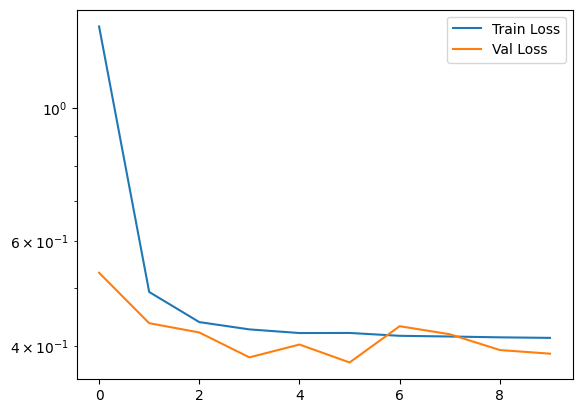

In [15]:
logger.plot_run(keys=['Train Loss', 'Val Loss'], log=True)

### Inference

In [16]:
def plot_images(images, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i][0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

In [17]:
def visualize_reconstruction_and_generation(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    idx = random.randint(0, len(data_loader)-1)
    for _ in range(idx):
        real_images = next(iter(data_loader))[:1]

    real_images = real_images.to(device)
    
    with torch.no_grad():
        reconstructed, _, _ = model(real_images)
    
    real_images = real_images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    print('Real')
    plot_map(lon_sst,lat_sst,real_images[0][0],'file_real.png')
    
    print('Reconstructed')
    plot_map(lon_sst,lat_sst,reconstructed[0][0],'file_recon.png')
    
    random_latent_vectors = torch.randn(5, 50, device=device)
    with torch.no_grad():
        new_images = model.decode(random_latent_vectors).cpu().numpy()
    
    print('New')
    plot_map(lon_sst,lat_sst,new_images[0][0],'file_new.png')

Real


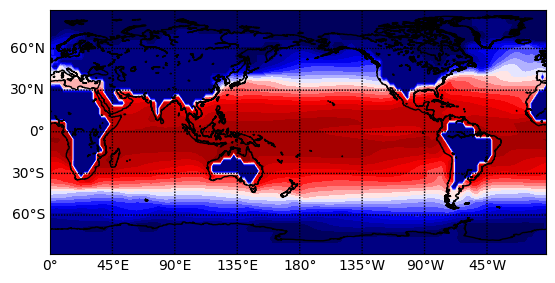

Reconstructed


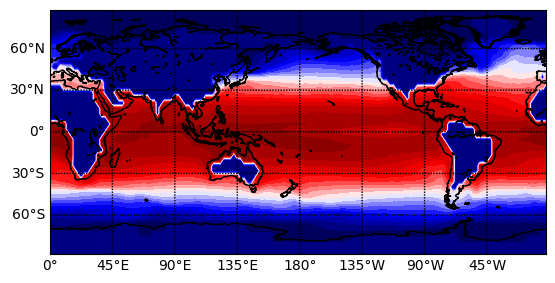

New


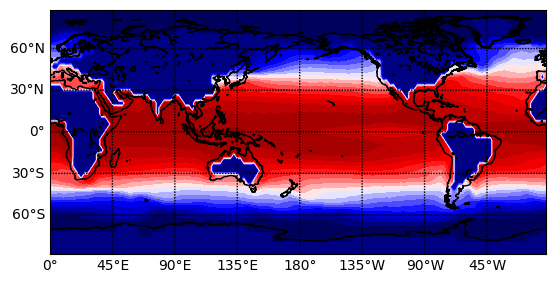

<Figure size 640x480 with 0 Axes>

In [18]:
visualize_reconstruction_and_generation(model, val_loader, device)

In [19]:
def generate_new_dataset(model, num_samples, lat, lon, output_path="generated_data.nc", device="cpu"):
    model.eval()
    model.to(device)
   
    latent_vectors = torch.randn(num_samples, 50, device=device)
   
    with torch.no_grad():
        generated_data = model.decode(latent_vectors).cpu().numpy()
   
    generated_data = generated_data.squeeze()

    with nc.Dataset(output_path, 'w', format='NETCDF4') as dataset:
        dataset.createDimension('sample', num_samples)
        dataset.createDimension('lat', len(lat))
        dataset.createDimension('lon', len(lon))
       
        latitudes = dataset.createVariable('lat', 'f4', ('lat',))
        longitudes = dataset.createVariable('lon', 'f4', ('lon',))
        sst = dataset.createVariable('sst', 'f4', ('sample', 'lat', 'lon'))
       
        latitudes[:] = lat
        longitudes[:] = lon
        sst[:, :, :] = generated_data
       
        dataset.description = "Generated SST data using a trained VAE model."
        dataset.history = f"Created on {pd.Timestamp.now()} using VAE."
        dataset.source = "VAE-generated dataset"
   
    print(f"Generated dataset saved to {output_path}.")

num_samples = 100
output_file = "generated_data.nc"

generate_new_dataset(model, num_samples, lat_sst, lon_sst, output_path=output_file, device='mps')

Generated dataset saved to generated_data.nc.


In [6]:
trY_SST_ds = nc.Dataset("generated_data.nc", decode_times=False)

generated = trY_SST_ds.variables['sst']
lat_sst=trY_SST_ds.variables['lat'][:]
lon_sst=trY_SST_ds.variables['lon'][:]

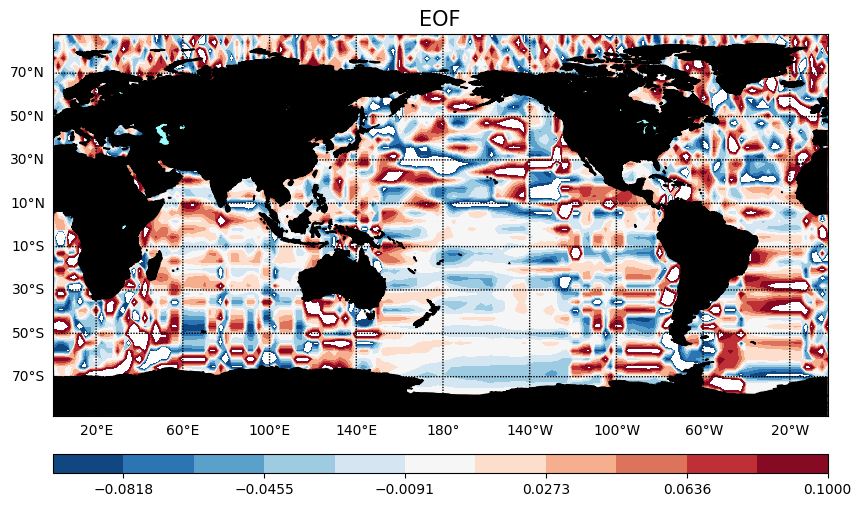

In [ ]:
def EOF(Data, lat, lon):
    wgts   = np.cos(np.deg2rad(lat))
    wgts   = wgts.reshape(len(wgts), 1)
    #solver1 = Eof(np.array(ser_original[6]), weights=wgts)

    coslat = np.cos(np.deg2rad(lat))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver =Eof(Data,weights=wgts)
    eof1=solver.eofs()

    pc=solver.pcs(pcscaling=1)
    varfrac=solver.varianceFraction()
    lambdas=solver.eigenvalues()


    parallels = np.arange(-90,90,20)
    meridians = np.arange(-180,180,40)

    fig=plt.figure(figsize=(10,16)) 

    m=Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat),
            urcrnrlon=max(lon), urcrnrlat=max(lat), resolution='l')
    x, y = m(*np.meshgrid(lon,lat))
    clevs = np.linspace(-0.1,0.1,12)

    cs = m.contourf(x,y,eof1.squeeze(),clevs,cmap=plt.cm.RdBu_r)
    m.drawcoastlines()
    m.fillcontinents(color='#000000',lake_color='#99ffff')
    m.drawparallels(parallels,labels=[1,0,0,0])
    m.drawmeridians(meridians,labels=[1,0,0,1])

    cb=m.colorbar(cs, 'bottom', size='5%',pad='10%')
    plt.title('EOF', fontsize=15)  
    plt.show()
    return eof1[0]

# Prepare the input data (using anomalies from the earlier code)
generated = np.array(generated)
trY_SST_anom = generated - np.expand_dims(generated.mean(1), 1)  # Anomalies

mean_anom = trY_SST_anom.mean(axis=0)

eof1_pattern = EOF(mean_anom, lat_sst, lon_sst)